In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
df = pd.read_csv('Tesla_stock_Price.csv')

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date').set_index('Date')

df.head()

<ipython-input-2-f0bffce43687>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2010-06-30,1.59,1.72,2.03,1.55,257.92M,0.00%
2010-07-01,1.46,1.67,1.73,1.35,123.45M,-8.18%
2010-07-02,1.28,1.53,1.54,1.25,77.13M,-12.33%
2010-07-06,1.07,1.33,1.33,1.06,103.19M,-16.41%
2010-07-07,1.05,1.09,1.11,1,103.87M,-1.87%


##Line Plot of 'Open' Price Over Time

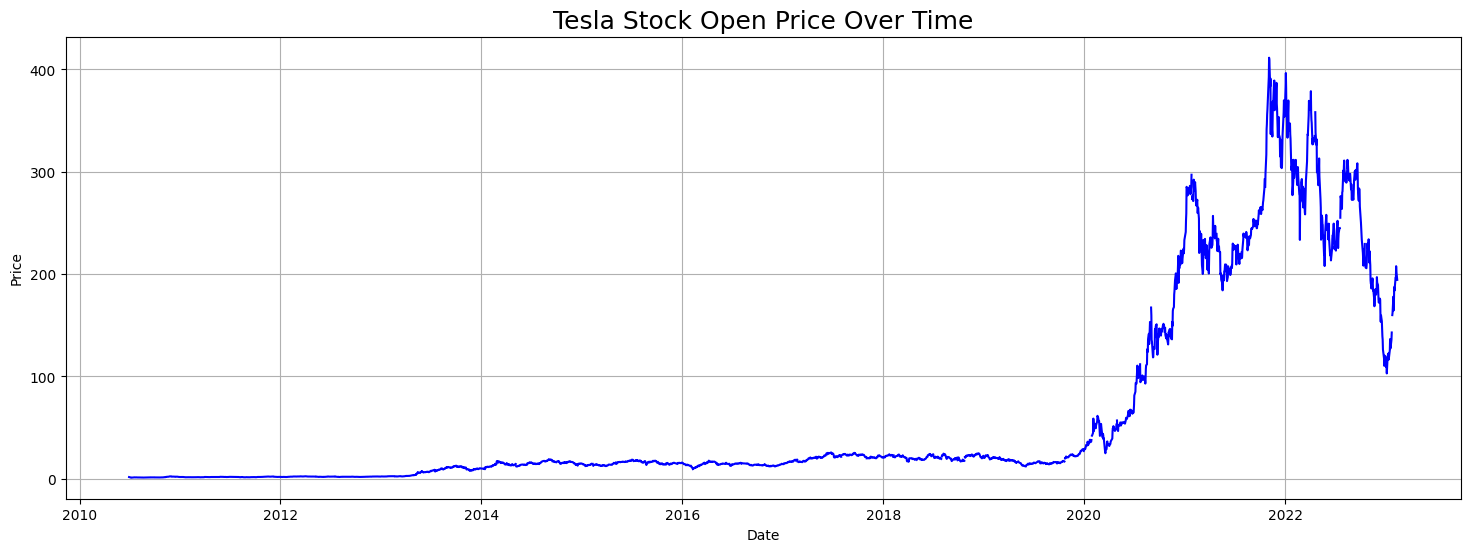

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(df['Open'], color='blue')
plt.title('Tesla Stock Open Price Over Time', fontsize=18)
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


##Use Only ‘Open’ Price

In [ ]:
data = df[['Open']].copy()
data.dropna(inplace=True)


## Scale Data

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


##Create Sequences

In [ ]:
def create_sequences(dataset, lookback=30):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

lookback = 30
X, y = create_sequences(scaled_data, lookback)


##Split Train & Test

In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


##Build Simple Tuned LSTM Model

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

##Train Model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=7, factor=0.5)

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 2.2119e-04 - val_loss: 6.2135e-04 - learning_rate: 0.0010
Epoch 2/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 1.6863e-05 - val_loss: 6.2926e-04 - learning_rate: 0.0010
Epoch 3/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.5262e-05 - val_loss: 8.0882e-04 - learning_rate: 0.0010
Epoch 4/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.3396e-05 - val_loss: 6.2142e-04 - learning_rate: 0.0010
Epoch 5/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.2312e-05 - val_loss: 4.8937e-04 - learning_rate: 0.0010
Epoch 6/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.2248e-05 - val_loss: 5.7513e-04 - learning_rate: 0.0010
Epoch 7/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.0268e-05 - val_loss: 6.3166e-04 - learning_rate: 0.0010
Epoch 8/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 9.2987e-06 - val_loss: 4.3429e-04 - learning_rate: 0.0010
Epoch 9/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - lo

##Predict & Evaluate

In [ ]:
y_pred = model.predict(X_test)

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
Test RMSE: 37.8621
Test MAE: 22.8247
Test R²: 0.7642


##Plot Results

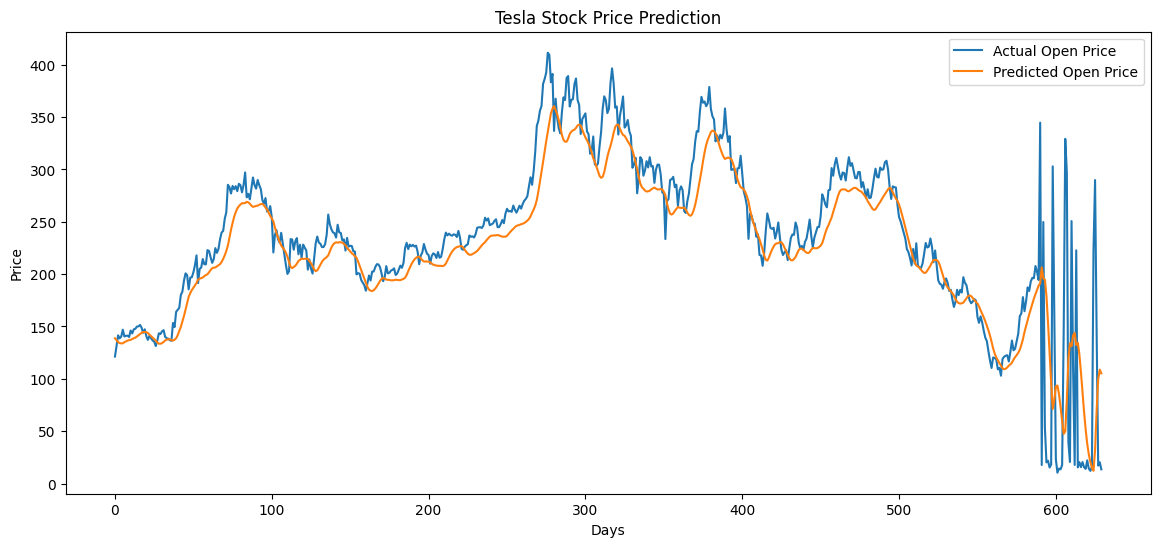

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Open Price')
plt.plot(y_pred_inv, label='Predicted Open Price')
plt.legend()
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()


## Build Bidirectional LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(lookback, 1)))
model_bilstm.add(Dropout(0.3))
model_bilstm.add(Bidirectional(LSTM(64)))
model_bilstm.add(Dropout(0.3))
model_bilstm.add(Dense(1))

model_bilstm.compile(optimizer='adam', loss='mse')
model_bilstm.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,601 (1.14 MB)

 Trainable params: 297,601 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)

history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=400,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - loss: 1.6391e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 2/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - loss: 1.4640e-05 - val_loss: 7.2421e-04 - learning_rate: 0.0010
Epoch 3/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - loss: 1.2079e-05 - val_loss: 6.5520e-04 - learning_rate: 0.0010
Epoch 4/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 1.1618e-05 - val_loss: 5.4922e-04 - learning_rate: 0.0010
Epoch 5/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - loss: 1.1644e-05 - val_loss: 4.5460e-04 - learning_rate: 0.0010
Epoch 6/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - loss: 8.5739e-06 - val_loss: 4.4183e-04 - learning_rate: 0.0010
Epoch 7/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - loss: 8.2514e-06 - val_loss: 6.0594e-04 - learning_rate: 0.0010
Epoch 8/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - loss: 8.1689e-06 - val_loss: 3.9627e-04 - learning_rate: 0.0010
Epoch 9/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 1

##Visualize Training & Validation Loss

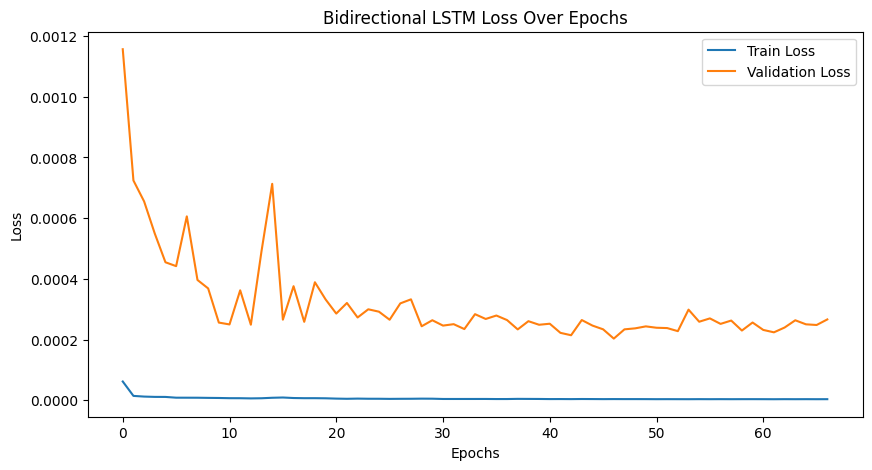

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_bilstm.history['loss'], label='Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


##Predict & Evaluate

In [ ]:
y_pred_bilstm = model_bilstm.predict(X_test)

# Inverse scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv_bilstm = scaler.inverse_transform(y_pred_bilstm)

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse_bilstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv_bilstm))
mae_bilstm = mean_absolute_error(y_test_inv, y_pred_inv_bilstm)
r2_bilstm = r2_score(y_test_inv, y_pred_inv_bilstm)

print(f"Bidirectional LSTM Test RMSE: {rmse_bilstm:.4f}")
print(f"Bidirectional LSTM Test MAE: {mae_bilstm:.4f}")
print(f"Bidirectional LSTM Test R²: {r2_bilstm:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
Bidirectional LSTM Test RMSE: 35.0461
Bidirectional LSTM Test MAE: 19.2597
Bidirectional LSTM Test R²: 0.7980


##Plot Predictions vs Actual

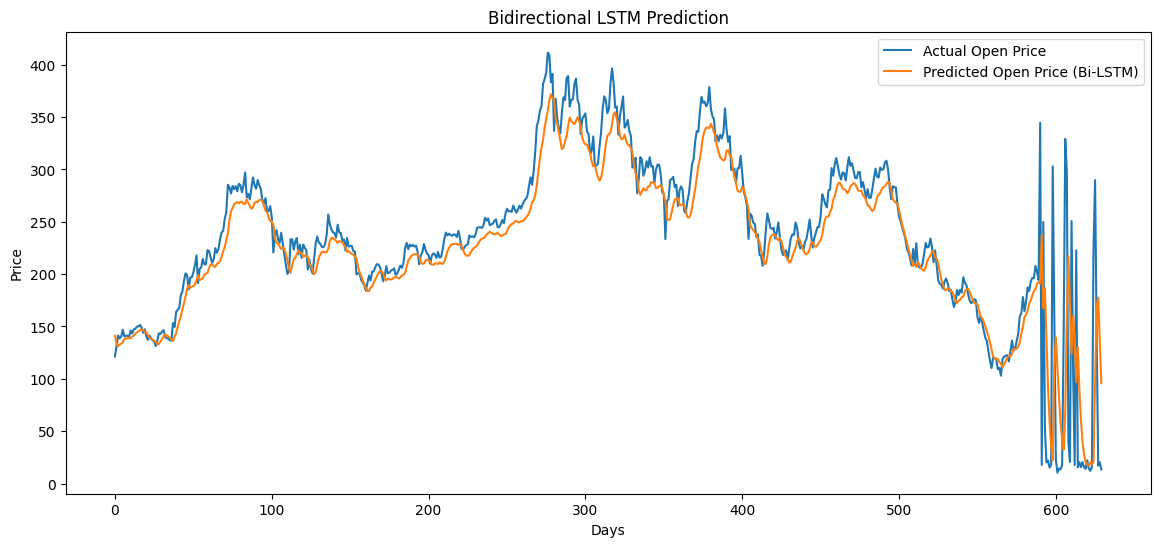

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Open Price')
plt.plot(y_pred_inv_bilstm, label='Predicted Open Price (Bi-LSTM)')
plt.title('Bidirectional LSTM Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


##Build Hybrid Model - Bi-LSTM + GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional

model_hybrid = Sequential()

# Bidirectional LSTM layer
model_hybrid.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(lookback, 1)))
model_hybrid.add(Dropout(0.3))

# GRU layer
model_hybrid.add(GRU(64))
model_hybrid.add(Dropout(0.3))

# Output layer
model_hybrid.add(Dense(1))

# Compile
model_hybrid.compile(optimizer='adam', loss='mse')

# Summary
model_hybrid.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,009 (761.75 KB)

 Trainable params: 195,009 (761.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)

history_hybrid = model_hybrid.fit(
    X_train, y_train,
    epochs=400,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - loss: 2.3829e-04 - val_loss: 3.1716e-04 - learning_rate: 0.0010
Epoch 2/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 1.3286e-05 - val_loss: 2.9371e-04 - learning_rate: 0.0010
Epoch 3/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 1.1031e-05 - val_loss: 3.0924e-04 - learning_rate: 0.0010
Epoch 4/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 1.3191e-05 - val_loss: 2.1474e-04 - learning_rate: 0.0010
Epoch 5/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 1.3304e-05 - val_loss: 2.9357e-04 - learning_rate: 0.0010
Epoch 6/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 8.6080e-06 - val_loss: 2.3534e-04 - learning_rate: 0.0010
Epoch 7/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 8.2734e-06 - val_loss: 2.2870e-04 - learning_rate: 0.0010
Epoch 8/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 1.1419e-05 - val_loss: 2.8772e-04 - learning_rate: 0.0010
Epoch 9/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 91m

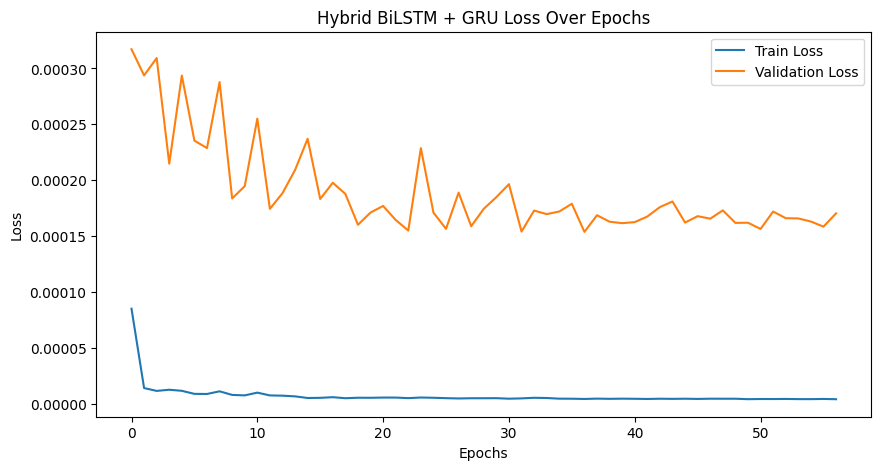

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_hybrid.history['loss'], label='Train Loss')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss')
plt.title('Hybrid BiLSTM + GRU Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
y_pred_hybrid = model_hybrid.predict(X_test)

# Inverse scale
y_pred_inv_hybrid = scaler.inverse_transform(y_pred_hybrid)

# Metrics
rmse_hybrid = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv_hybrid))
mae_hybrid = mean_absolute_error(y_test_inv, y_pred_inv_hybrid)
r2_hybrid = r2_score(y_test_inv, y_pred_inv_hybrid)

print(f"Hybrid BiLSTM + GRU Test RMSE: {rmse_hybrid:.4f}")
print(f"Hybrid BiLSTM + GRU Test MAE: {mae_hybrid:.4f}")
print(f"Hybrid BiLSTM + GRU Test R²: {r2_hybrid:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Hybrid BiLSTM + GRU Test RMSE: 32.6802
Hybrid BiLSTM + GRU Test MAE: 14.3489
Hybrid BiLSTM + GRU Test R²: 0.8244


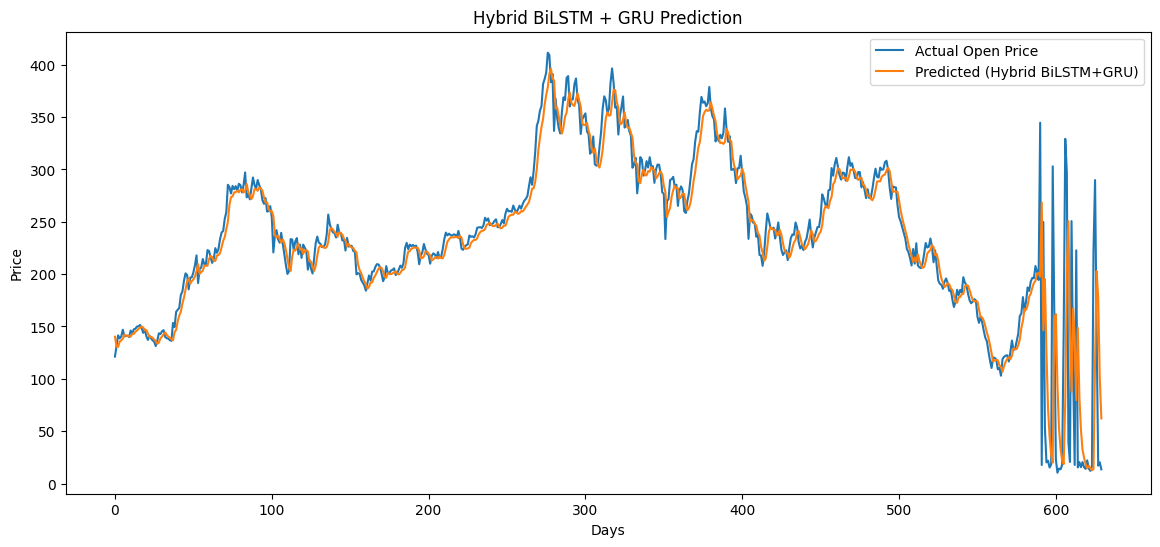

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Open Price')
plt.plot(y_pred_inv_hybrid, label='Predicted (Hybrid BiLSTM+GRU)')
plt.title('Hybrid BiLSTM + GRU Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


⚠️ Why are our results very different from the research paper?
The paper had:

Test RMSE: ~7.44, R²: ~0.95+

You have:

Test RMSE: ~32.68, R²: ~0.82

🔍 Key Differences & Possible Reasons:
❌ 1. We used full dataset (2013–2023)
✅ Paper used only 2022–2023 (478 rows) — much tighter range, smaller price variation (100–400)

📉 Why it matters:

Early years (2013–2020) had very low prices (e.g., $2, $10)

Later years (2021–23) had high volatility, price 800+, stock splits, etc.

LSTM struggles to model long, uneven sequences unless trained very carefully

👉 Fix: Filter data:

python
Copy
Edit
df_recent = df['2022-01-01':]
❌ 2. We're predicting raw ‘Open’ price
✅ They likely normalized, used deltas, or trained on closing prices only, which have smoother signals.

👉 Fix: Focus only on 'Close' (if more stable), or use returns like:

python
Copy
Edit
df['Close_diff'] = df['Close'].diff()
❌ 3. Missing returns, trends, or indicators
✅ They might have used moving averages, momentum, rolling means, etc. — we only used raw Open price.

👉 Adding:

python
Copy
Edit
df['MA20'] = df['Open'].rolling(20).mean()
df['Open_diff'] = df['Open'].diff()
❌ 4. We skipped full model tuning
✅ Their model used carefully tuned layers, dropout, early stopping, and a smaller batch size (5).
We’ve done a lot of tuning — but could be more targeted.

👉 Try tuning:

batch_size=16 or 8

different learning rates

different optimizers (adam, nadam, rmsprop)

❌ 5. Our target may be wrongly scaled
✅ It’s CRITICAL to inverse-transform only the predicted column, not the whole row — we’re doing it right, but just keep this double-checked.

✅ What should we do now?
If you want to get much closer to the paper’s results, here's the best next step:

🛠 LET’S RESET AND DO:
Use only 2022–2023 data

Predict only on 'Close' prices

Limit lookback window to 30

Train on 65%-35% split (same as paper)

Reuse our best hybrid model architecture



##Load & Filter Data to 2022–2023

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('Tesla_stock_Price.csv')

# Safely convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Coerce invalid dates to NaT

# Drop rows with invalid or missing dates
df = df.dropna(subset=['Date'])

# Sort by Date and set it as the index
df = df.sort_values('Date').set_index('Date')

# Use only 'Close' column, filter dates for 2022–2023
df = df[['Price']].rename(columns={'Price': 'Close'})
df = df.loc['2022-01-01':'2023-12-31'].copy()  # Use loc to filter by date range

# Print filtered dataset shape and display the first few rows
print("Filtered dataset shape:", df.shape)
print(df.head())


Filtered dataset shape: (280, 1)
             Close
Date              
2022-01-03  399.93
2022-01-04  383.20
2022-01-05  362.71
2022-01-06  354.90
2022-01-07  342.32


<ipython-input-18-c0dbf3268b4c>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Coerce invalid dates to NaT


In [ ]:
df.dropna(inplace=True)


In [ ]:
df.reset_index(drop=True, inplace=True)


##Visualize the Filtered 'Close' Prices

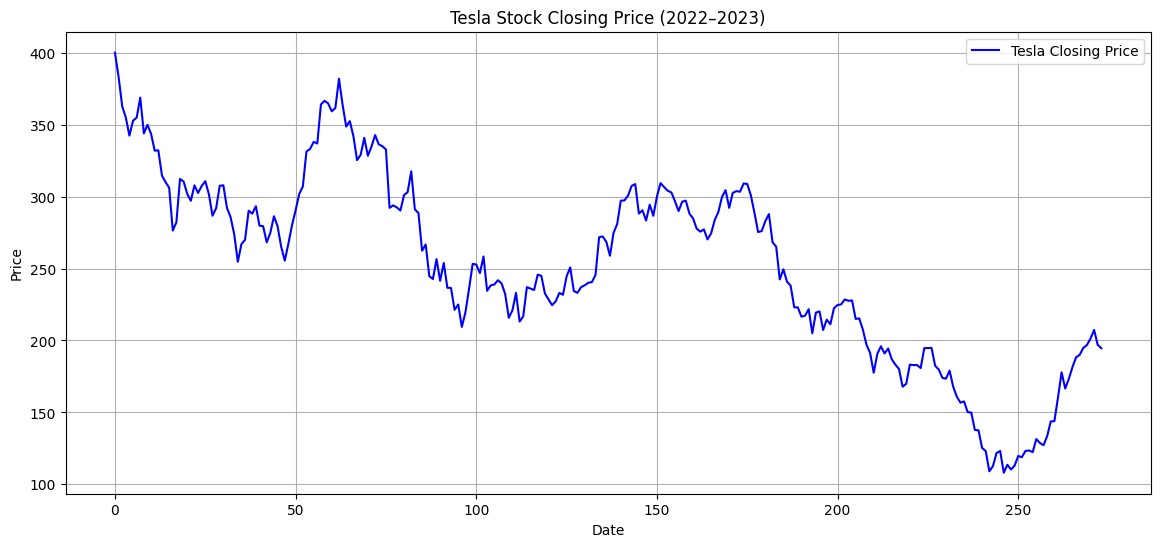

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Tesla Closing Price', color='blue')
plt.title('Tesla Stock Closing Price (2022–2023)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()


##Scale Data & Create Sequences

In [ ]:
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']])


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']])

def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

lookback = 30
X, y = create_sequences(scaled_close, lookback)

# Train-Test Split (65%-35% as in paper)
split = int(0.65 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (158, 30, 1) Test shape: (86, 30, 1)


##Build Hybrid BiLSTM + GRU Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(lookback, 1)))
model.add(Dropout(0.3))
model.add(GRU(32))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 30, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,377 (192.88 KB)

 Trainable params: 49,377 (192.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=7, factor=0.5)

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.1949 - val_loss: 0.0550 - learning_rate: 0.0010
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0480 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0228 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0130 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0135 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0164 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0125 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0150 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0115 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 10/300
9/9 ━━━━━━━━━━

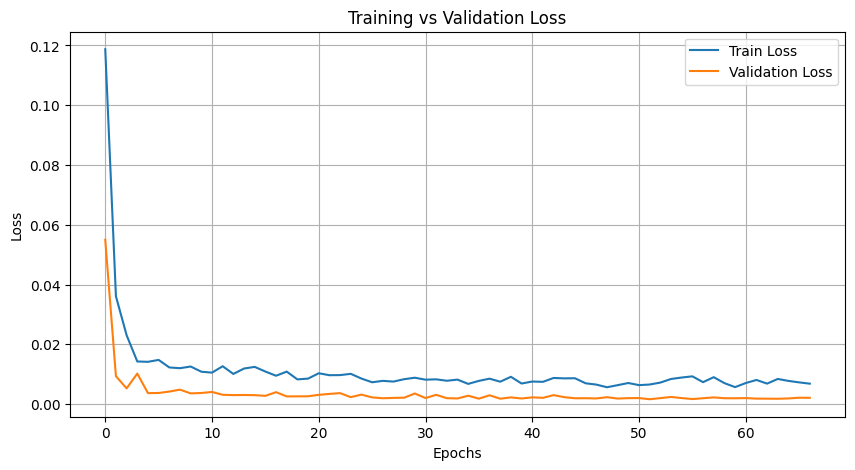

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Hybrid Model (Filtered 2022–2023)")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² : {r2:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step
Hybrid Model (Filtered 2022–2023)
Test RMSE: 13.6579
Test MAE: 11.0315
Test R² : 0.8561


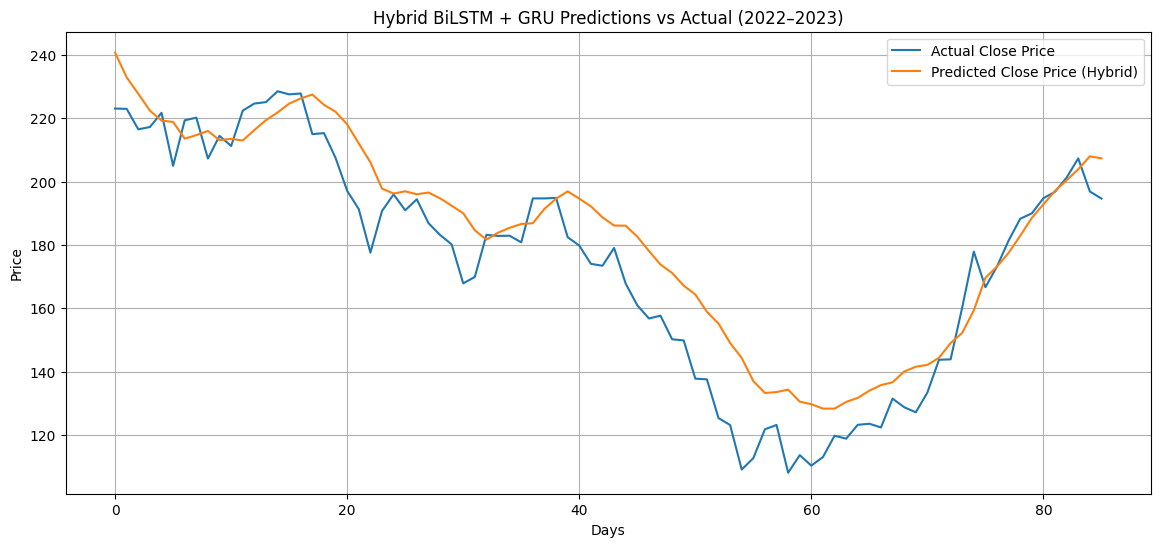

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Close Price')
plt.plot(y_pred_inv, label='Predicted Close Price (Hybrid)')
plt.title('Hybrid BiLSTM + GRU Predictions vs Actual (2022–2023)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
